In [1]:
import numpy as np
from scipy import stats
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

DIFFERENT ALPHAS


In [2]:
# Define the inner function
def inner_func(a, s, x=1, alpha=0.95):
    u = np.sqrt(s) - x - a
    v = -np.sqrt(s) - x - a

    term1 = (x**2 + a**2 + 2*x*a - s + 1) * (1 - stats.norm.cdf(u) + stats.norm.cdf(v))
    term2 = (np.sqrt(s) + x + a) * stats.norm.pdf(u)
    term3 = (np.sqrt(s) - x - a) * stats.norm.pdf(v)

    result = x**2 + a**2 + (1 / (1 - alpha)) * (term1 + term2 + term3)
    return result

# Define function to find optimal a* for given s
def optimal_a(s, x=1, alpha=0.95):
    res = minimize(inner_func, x0=0, args=(s, x, alpha), method='L-BFGS-B', bounds=[(-10, 10)])
    return res.x[0]

# Define the outer function
def outer_func(s, x=1, alpha=0.95):
    a_star = optimal_a(s, x, alpha)
    return s + inner_func(a_star, s, x, alpha)

# Set bounds and ranges
bounds_s = [(0, 50)]
x_values = np.arange(0.0, 21, 1)
s_values = np.arange(0.0, 52, 2)
alpha_values = [0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.99]

results = {}

In [3]:
# Loop over alpha values
for alpha in alpha_values:
    a_optimal = []
    s_optimal = []
    objective_values = []

    print(f"Processing alpha = {alpha}...")

    for x in x_values:
        for s in s_values:
            res_s = minimize(outer_func, x0=0.1, bounds=bounds_s, args=(x, alpha), method='L-BFGS-B')
            a_optimal.append(optimal_a(s, x, alpha))
            s_optimal.append(res_s.x[0])
            objective_values.append(res_s.fun)

    # Save df1
    df1 = pd.DataFrame({
        'x': np.repeat(x_values, len(s_values)),
        's': np.tile(s_values, len(x_values)),
        'a*(x,s)': a_optimal
    })

    # Save df2
    df2_data = []
    num_s = len(s_values)

    for i, x in enumerate(x_values):
        s_slice = s_optimal[i*num_s:(i+1)*num_s]
        obj_slice = objective_values[i*num_s:(i+1)*num_s]
        min_idx = np.argmin(obj_slice)

        df2_data.append({
            'x': x,
            's*(x)': s_slice[min_idx],
            'V(x)': obj_slice[min_idx]
        })

    df2 = pd.DataFrame(df2_data)

    # Store results by alpha
    results[alpha] = {
        'df1': df1,
        'df2': df2
    }



Processing alpha = 0.4...
Processing alpha = 0.5...
Processing alpha = 0.6...
Processing alpha = 0.7...
Processing alpha = 0.8...
Processing alpha = 0.9...
Processing alpha = 0.99...


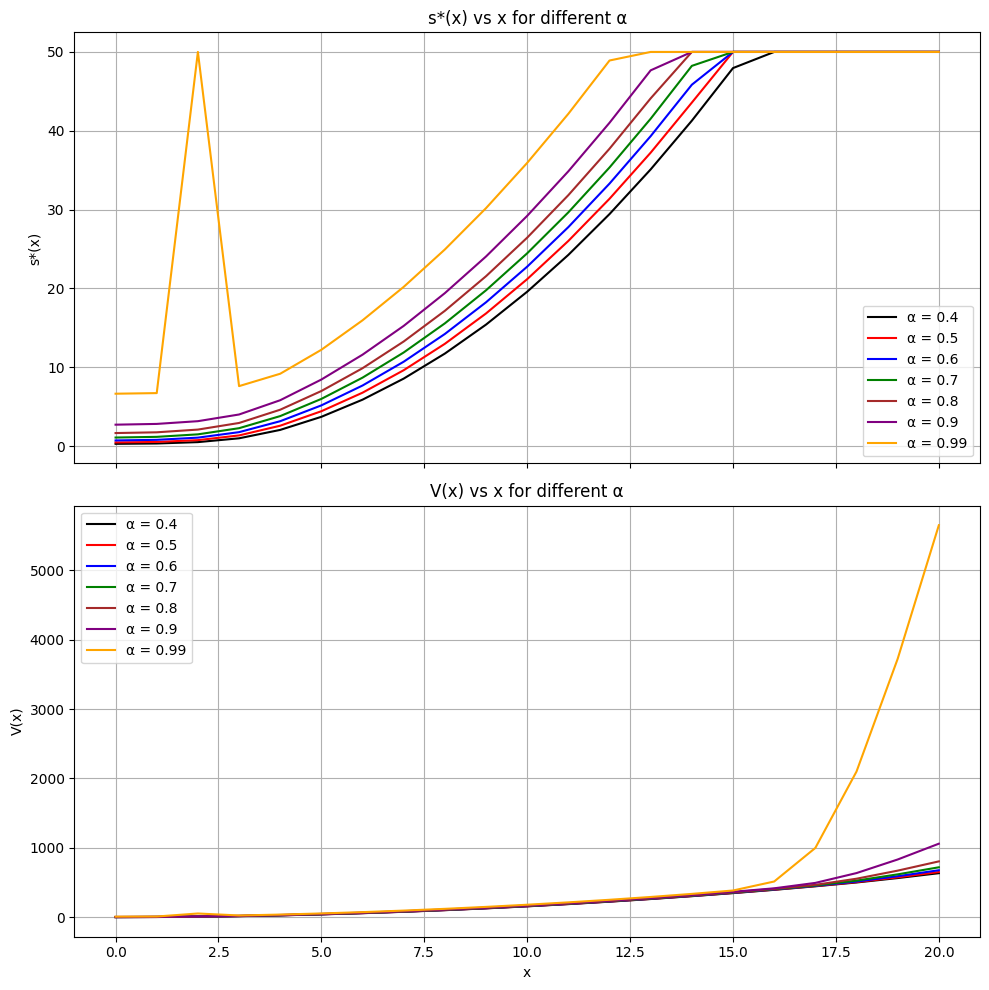

In [4]:
# Set up the plots
fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# Manually set distinct colors
custom_colors = ['black', 'red', 'blue', 'green', 'brown', 'purple', 'orange']

# Plot s*(x) vs x
for i, alpha in enumerate(alpha_values):
    df2 = results[alpha]['df2']
    axs[0].plot(df2['x'], df2['s*(x)'], label=f'α = {alpha}', color=custom_colors[i])

axs[0].set_title('s*(x) vs x for different α')
axs[0].set_ylabel('s*(x)')
axs[0].legend()
axs[0].grid(True)

# Plot V(x) vs x
for i, alpha in enumerate(alpha_values):
    df2 = results[alpha]['df2']
    axs[1].plot(df2['x'], df2['V(x)'], label=f'α = {alpha}', color=custom_colors[i])

axs[1].set_title('V(x) vs x for different α')
axs[1].set_xlabel('x')
axs[1].set_ylabel('V(x)')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


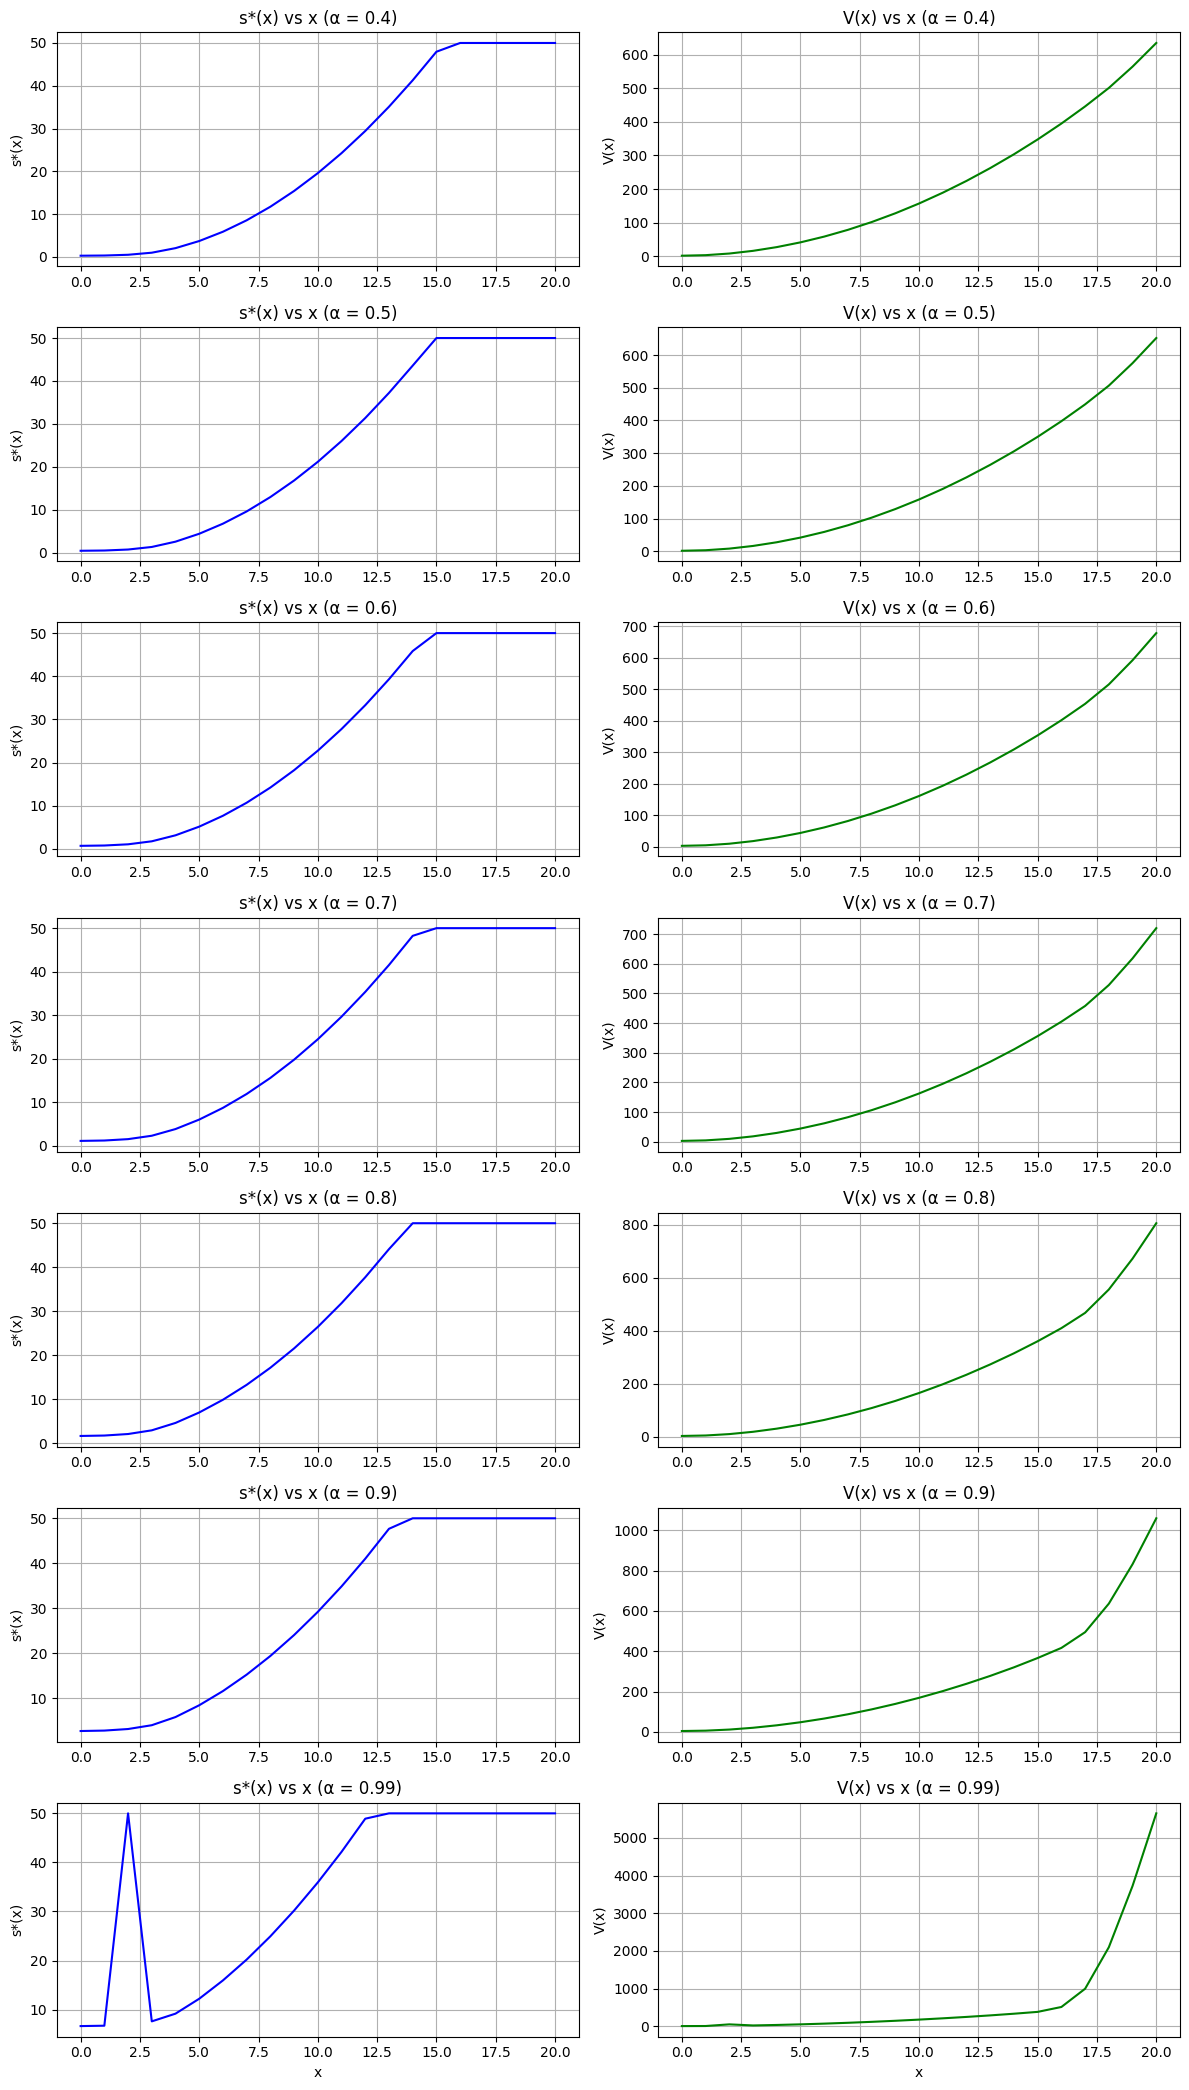

In [5]:
fig, axs = plt.subplots(len(alpha_values), 2, figsize=(12, 3 * len(alpha_values)))

for i, alpha in enumerate(alpha_values):
    df2 = results[alpha]['df2']
    
    axs[i, 0].plot(df2['x'], df2['s*(x)'], color='blue')
    axs[i, 0].set_title(f's*(x) vs x (α = {alpha})')
    axs[i, 0].set_ylabel('s*(x)')
    axs[i, 0].grid(True)

    axs[i, 1].plot(df2['x'], df2['V(x)'], color='green')
    axs[i, 1].set_title(f'V(x) vs x (α = {alpha})')
    axs[i, 1].set_ylabel('V(x)')
    axs[i, 1].grid(True)

axs[-1, 0].set_xlabel('x')
axs[-1, 1].set_xlabel('x')

plt.tight_layout()
plt.show()


In [6]:
for alpha, data in results.items():
    print(f"\nResults for alpha = {alpha}")
    display(data['df1']) 
    display(data['df2'])


Results for alpha = 0.4


,x,s,"a*(x,s)"
0,0.0,0.0,0.0
1,0.0,2.0,0.0
2,0.0,4.0,0.0
3,0.0,6.0,0.0
4,0.0,8.0,0.0
...,...,...,...
541,20.0,42.0,-10.0
542,20.0,44.0,-10.0
543,20.0,46.0,-10.0
544,20.0,48.0,-10.0


,x,s*(x),V(x)
0,0.0,0.274996,1.607767
1,1.0,0.318525,3.223668
2,2.0,0.493103,8.062375
3,3.0,0.976767,16.085347
4,4.0,2.043648,27.206648
5,5.0,3.704731,41.349116
6,6.0,5.879317,58.492988
7,7.0,8.551829,78.636892
8,8.0,11.728613,101.780796
9,9.0,15.404420,127.924700



Results for alpha = 0.5


,x,s,"a*(x,s)"
0,0.0,0.0,0.0
1,0.0,2.0,0.0
2,0.0,4.0,0.0
3,0.0,6.0,0.0
4,0.0,8.0,0.0
...,...,...,...
541,20.0,42.0,-10.0
542,20.0,44.0,-10.0
543,20.0,46.0,-10.0
544,20.0,48.0,-10.0


,x,s*(x),V(x)
0,0.0,0.454937,1.857348
1,1.0,0.514319,3.506361
2,2.0,0.743630,8.439372
3,3.0,1.341053,16.600087
4,4.0,2.576190,27.874578
5,5.0,4.414684,42.171139
6,6.0,6.765480,59.468998
7,7.0,9.616482,79.766882
8,8.0,12.967815,103.064767
9,9.0,16.818640,129.362651



Results for alpha = 0.6


,x,s,"a*(x,s)"
0,0.0,0.0,0.0
1,0.0,2.0,0.0
2,0.0,4.0,0.0
3,0.0,6.0,0.0
4,0.0,8.0,0.0
...,...,...,...
541,20.0,42.0,-10.0
542,20.0,44.0,-10.0
543,20.0,46.0,-10.0
544,20.0,48.0,-10.0


,x,s*(x),V(x)
0,0.0,0.708326,2.178109
1,1.0,0.782479,3.862050
2,2.0,1.060803,8.894765
3,3.0,1.757634,17.202541
4,4.0,3.147204,28.643017
5,5.0,5.155262,43.107563
6,6.0,7.675388,60.573396
7,7.0,10.695630,81.039252
8,8.0,14.216214,104.505108
9,9.0,18.235490,130.970965



Results for alpha = 0.7


,x,s,"a*(x,s)"
0,0.0,0.0,0.0
1,0.0,2.0,0.0
2,0.0,4.0,0.0
3,0.0,6.0,0.0
4,0.0,8.0,0.0
...,...,...,...
541,20.0,42.0,-10.0
542,20.0,44.0,-10.0
543,20.0,46.0,-10.0
544,20.0,48.0,-10.0


,x,s*(x),V(x)
0,0.0,1.074193,2.611024
1,1.0,1.160781,4.332349
2,2.0,1.479287,9.472916
3,3.0,2.259476,17.943821
4,4.0,3.796946,29.573487
5,5.0,5.978008,44.231056
6,6.0,8.672290,61.890008
7,7.0,11.867354,82.548983
8,8.0,15.562056,106.207958
9,9.0,19.757328,132.866934



Results for alpha = 0.8


,x,s,"a*(x,s)"
0,0.0,0.0,0.0
1,0.0,2.0,0.0
2,0.0,4.0,0.0
3,0.0,6.0,0.0
4,0.0,8.0,0.0
...,...,...,...
541,20.0,42.0,-10.0
542,20.0,44.0,-10.0
543,20.0,46.0,-10.0
544,20.0,48.0,-10.0


,x,s*(x),V(x)
0,0.0,1.642385,3.249102
1,1.0,1.737577,5.011818
2,2.0,2.082846,10.274066
3,3.0,2.922733,18.936897
4,4.0,4.604954,30.799345
5,5.0,6.979111,45.697450
6,6.0,9.870300,63.597234
7,7.0,13.261952,84.497043
8,8.0,17.153757,108.396853
9,9.0,21.545554,135.296662



Results for alpha = 0.9


,x,s,"a*(x,s)"
0,0.0,0.0,0.0
1,0.0,2.0,0.0
2,0.0,4.0,0.0
3,0.0,6.0,0.0
4,0.0,8.0,0.0
...,...,...,...
541,20.0,42.0,-10.0
542,20.0,44.0,-10.0
543,20.0,46.0,-10.0
544,20.0,48.0,-10.0


,x,s*(x),V(x)
0,0.0,2.705546,4.392861
1,1.0,2.802526,6.205574
2,2.0,3.149924,11.618902
3,3.0,3.997529,20.535687
4,4.0,5.809683,32.731770
5,5.0,8.434177,47.984073
6,6.0,11.587708,66.239019
7,7.0,15.241447,87.494002
8,8.0,19.397453,111.748985
9,9.0,24.048314,139.003968



Results for alpha = 0.99


,x,s,"a*(x,s)"
0,0.0,0.0,0.0
1,0.0,2.0,0.0
2,0.0,4.0,0.0
3,0.0,6.0,0.0
4,0.0,8.0,0.0
...,...,...,...
541,20.0,42.0,-10.0
542,20.0,44.0,-10.0
543,20.0,46.0,-10.0
544,20.0,48.0,-10.0


,x,s*(x),V(x)
0,0.0,6.634895,8.449166
1,1.0,6.711710,10.342279
2,2.0,50.000000,54.000053
3,3.0,7.597297,25.389968
4,4.0,9.168897,38.326516
5,5.0,12.210679,54.474832
6,6.0,15.947231,73.639819
7,7.0,20.191000,95.805032
8,8.0,24.937297,120.970246
9,9.0,30.182383,149.135460



--- Alpha = 0.4 ---


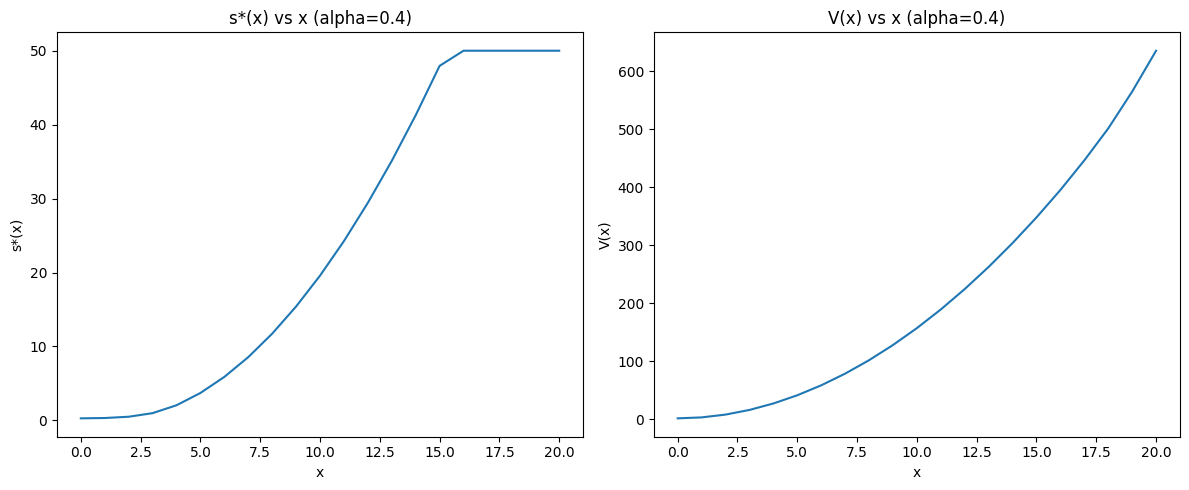


--- Alpha = 0.5 ---


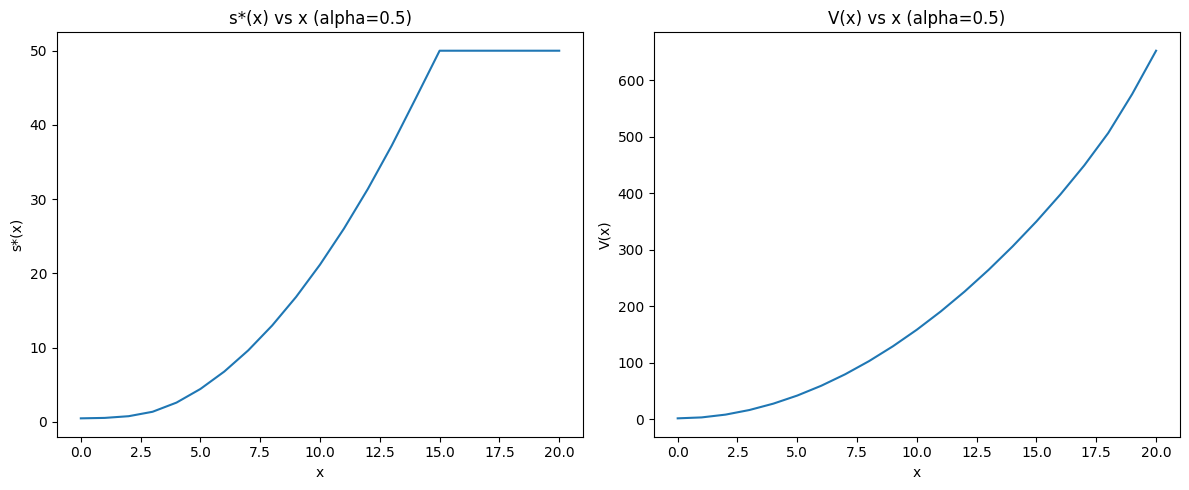


--- Alpha = 0.6 ---


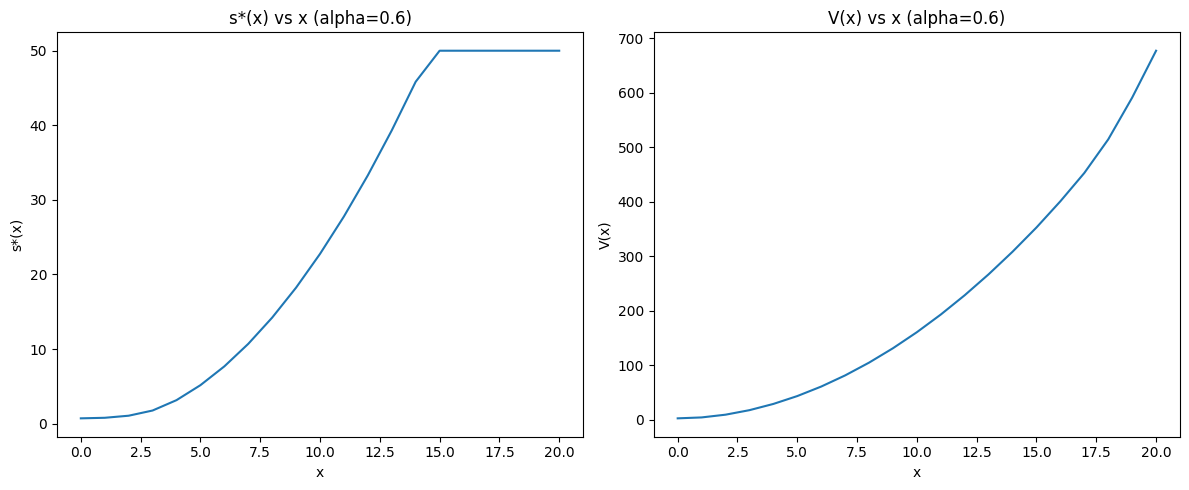


--- Alpha = 0.7 ---


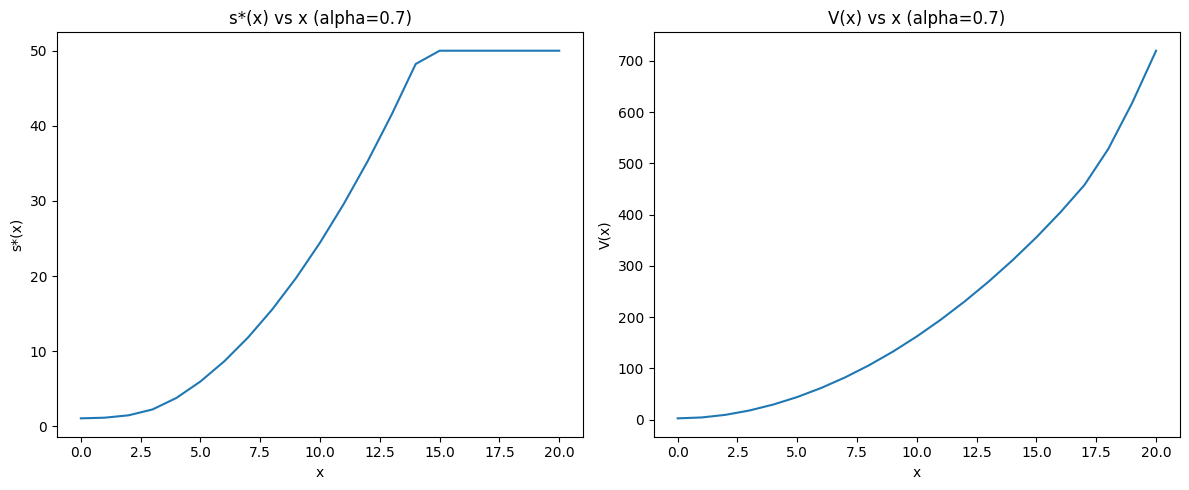


--- Alpha = 0.8 ---


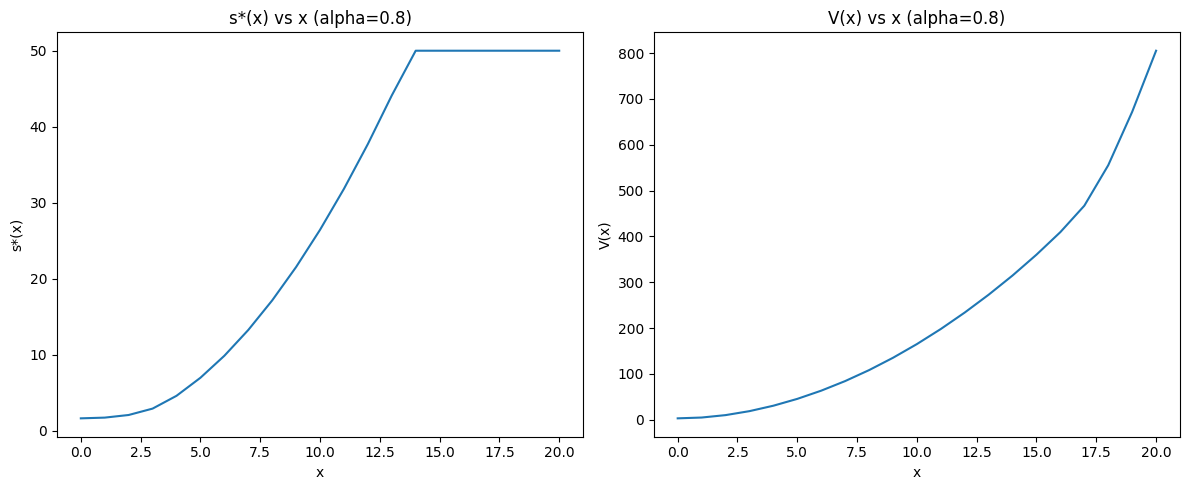


--- Alpha = 0.9 ---


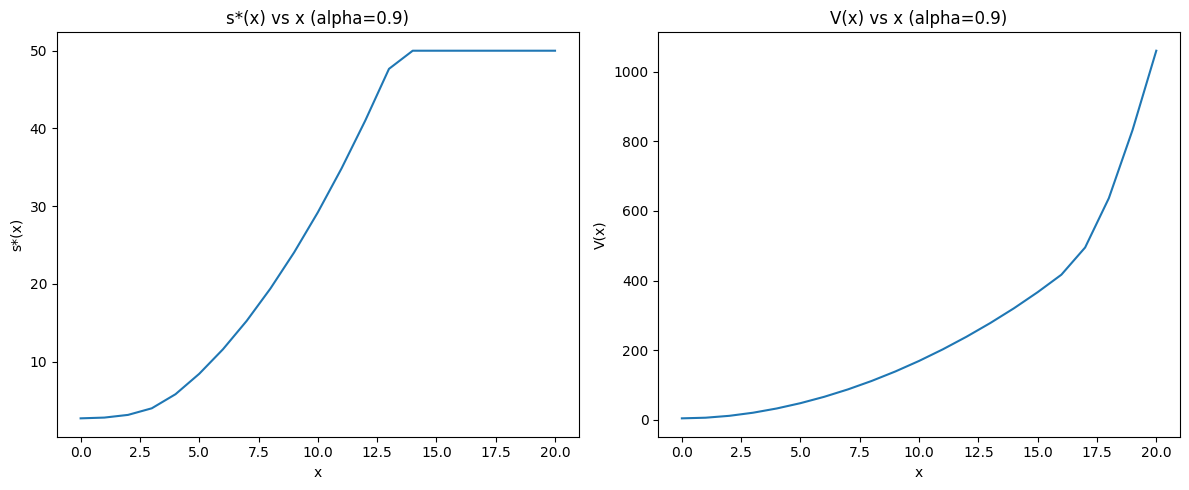


--- Alpha = 0.99 ---


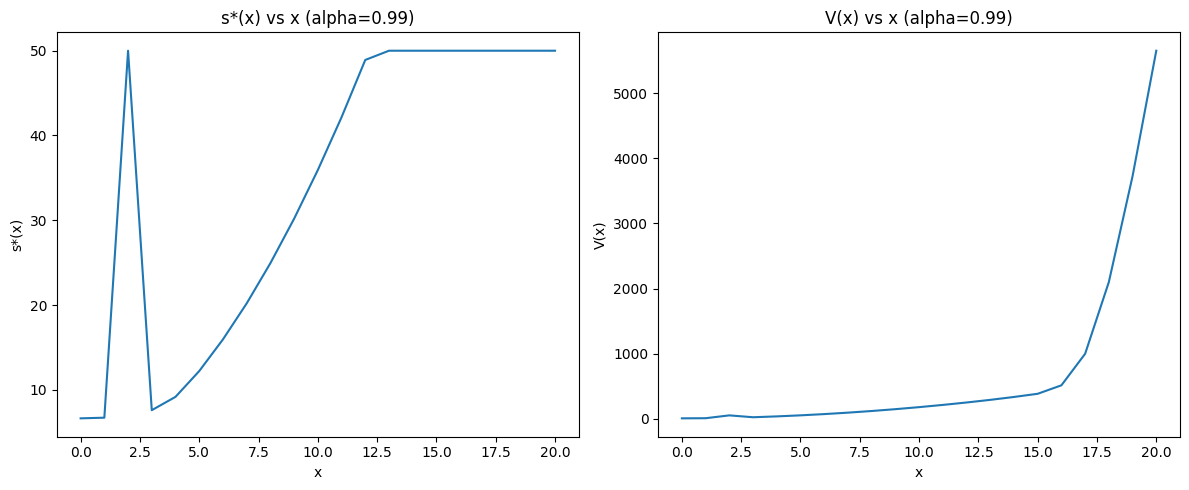

In [7]:
for alpha, data in results.items():
    df1 = data['df1']
    df2 = data['df2']
    
    print(f"\n--- Alpha = {alpha} ---")

    # Plot s*(x) and V(x)
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(df2['x'], df2['s*(x)'])
    plt.title(f's*(x) vs x (alpha={alpha})')
    plt.xlabel('x')
    plt.ylabel('s*(x)')
    
    plt.subplot(1, 2, 2)
    plt.plot(df2['x'], df2['V(x)'])
    plt.title(f'V(x) vs x (alpha={alpha})')
    plt.xlabel('x')
    plt.ylabel('V(x)')
    
    plt.tight_layout()
    plt.show()



--- Alpha = 0.4 ---


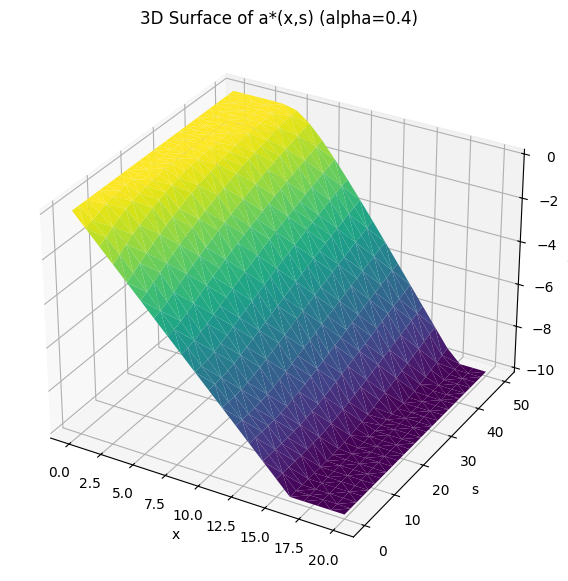


--- Alpha = 0.5 ---


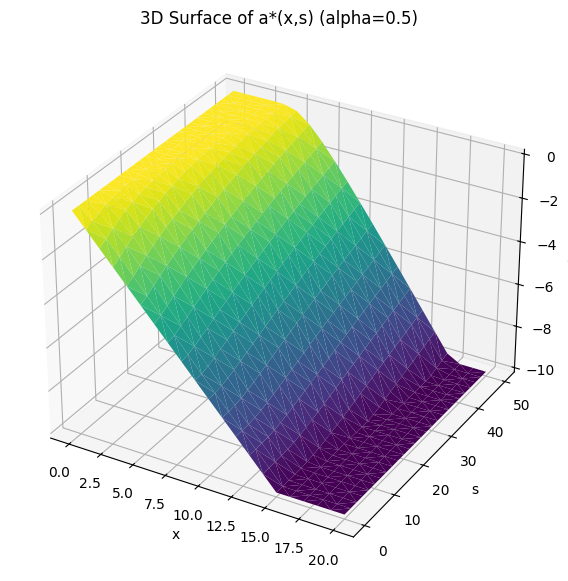


--- Alpha = 0.6 ---


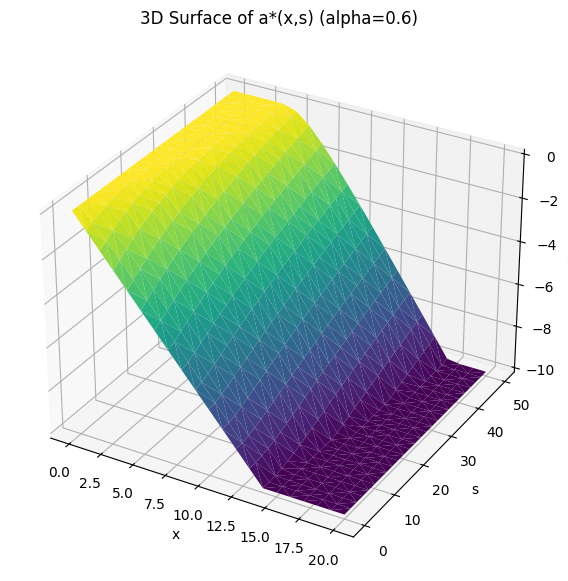


--- Alpha = 0.7 ---


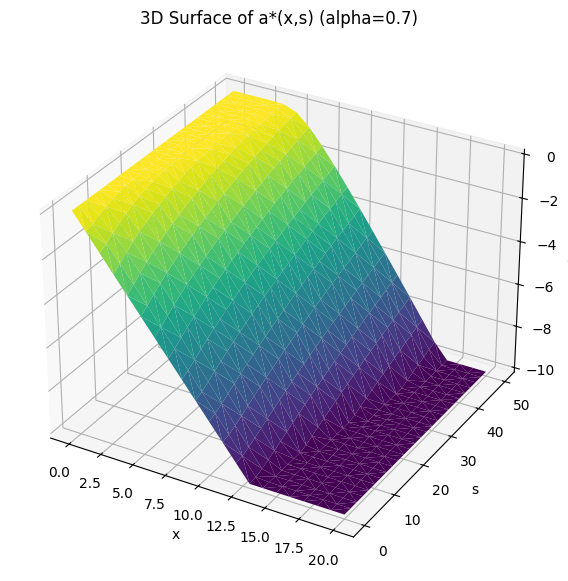


--- Alpha = 0.8 ---


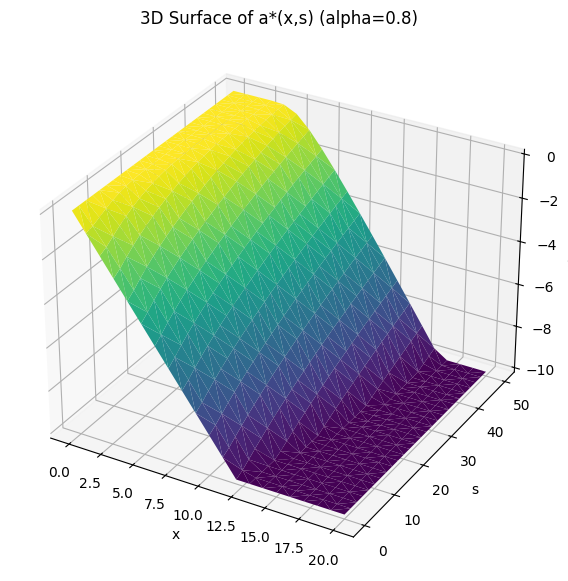


--- Alpha = 0.9 ---


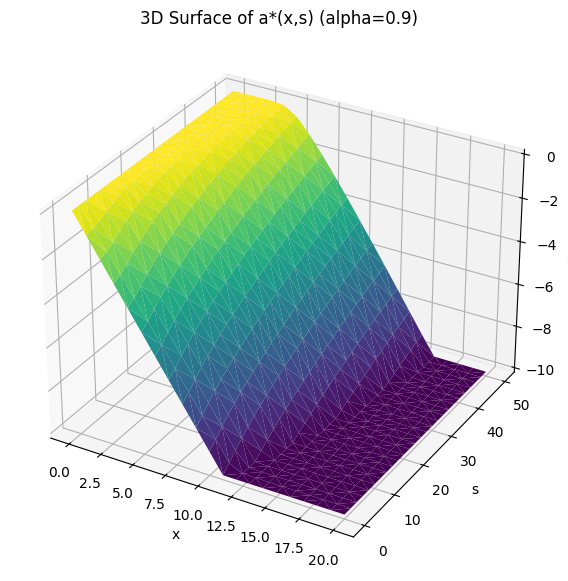


--- Alpha = 0.99 ---


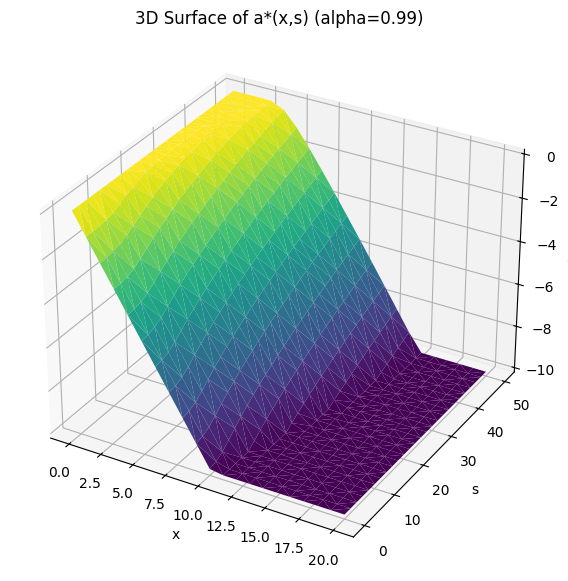

In [8]:
from mpl_toolkits.mplot3d import Axes3D  
for alpha, data in results.items():
    df1 = data['df1']
    df2 = data['df2']
    
    print(f"\n--- Alpha = {alpha} ---")
    
    # 🔼 3D plot of a*(x,s)
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    x_vals = df1['x'].values
    s_vals = df1['s'].values
    a_vals = df1['a*(x,s)'].values

    ax.plot_trisurf(x_vals, s_vals, a_vals, cmap='viridis', edgecolor='none')
    ax.set_xlabel('x')
    ax.set_ylabel('s')
    ax.set_zlabel('a*(x,s)')
    ax.set_title(f'3D Surface of a*(x,s) (alpha={alpha})')
    
    plt.show()
